In [47]:
import numpy as np

#(Import some plotting library for visualization.)
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
# here we set some aesthetic parameters so that all of our figures are nice and big
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 14
sns.set(style="white", context="talk")

This section will describe bootstrap methods for parameters inference. Should have a few examples of increasing complexity.
- Simple parameter inference bootstrap
- Simple hypothesis test
- More detailed Regression example
- block bootstrap and other time series methods

**Introduction** 

In the last section, we had our first encounter with notion of a *sampling distribution*. This is a pillar of frequentist inference and it allows us to ask the question What other outcomes might I have seen if I had repeated this experiment? A common approach is to rely on assumptions about the underlying data and then turn to some useful analytical expressions for the sampling distribution. Such an approach has been the bedrock of statistics from 1890s to the 1980s. These approaches, which are likely familiar to you, begin with assumptions about the data-generating process (drawn from Normal theory) and result in common methods such as ANOVA, t-tests, regression and others. When the data-generating process is non-Normal, then we need to turn to alternative methods. We previously described how we can use Monte Carlo methods to directly simulate the data-generating process and collect the outcomes of a large number of different experiments. We thus simulate any sampling distribution of interest, no matter what process has generated the data. All we have to do is be able to simulate new data. 

On some occasions, however, we might not have any clue about the data-generating process. We don't know if the data are Normally dsitributed, we don't know anything about it, so we can't rely on classical theory. And we can't rely on Monte Carlo methods, since we can't just directly simulate repeated experiments. But we want to estimate a sampling distribution, even though we assume nothing about the data. This seemingly impossible ask is the purview of Bootstrap Resampling. 

**The Bootstrap**

The goal of bootstrapping is to simulate repeated experimentation simply by *resampling* the data in a particular way. It may be hard to believe, but we can resample the observed data in order to generate a *synthetic* dataset. This synthetic dataset is meant to mimic the process of repeating an experiment, so we can treat the synthetic dataset as if it were a new set of observations from another experiment. We can compute whatever summary we want (test statistic) from the synthetic dataset and then save that for later. We then go back to the original data again and generate a new synthetic dataset. And so on. After some thousands of iterations of this process, we will gather thousands of different values of the test statistic. These are samples from the true sampling distribution of the test statistic. And that's it. We didn't assume anything about the data, we just used random sampling, and magically we get an approximation of the sampling distribution. The only thing we need to think about is making sure that we generate synthetic data sets using a process called *sampling with replacement*.


**Sample With Replacement**

The primary driver of bootstrapping is a resampling procedure called sampling with replacement. The idea is that we draw random samples from our data set one at a time, we jot down which one we drew, and then put that one back in the collection so that it could possibly be drawn again. Let's focus on the sample-with-replacement idea with some toy problems. Imagine we have this collection of fruits:

In [1]:
fruits = ["banana","apple","grape","pineapple","orange"]

In [2]:
# this function allows us to draw random samples from a collection
from numpy.random import choice

In [8]:
print choice(fruits)
print choice(fruits)
print choice(fruits)

pineapple
orange
grape


When we want to sample with replacement, we simply need to draw a single element, and then make sure we put it back, so that we have the original collection back again where it started. Well equivalently, we could just make successive independent draws (of just one sample) from the collection, like we just did above. And we use this process to generate a new collection of the exact same size as the original.

In [3]:
synthetic_dataset = [choice(fruits) for i in range(len(fruits))]
print synthetic_dataset

['grape', 'apple', 'banana', 'apple', 'banana']


Notice that because of the randomness of this process, the synthetic dataset will likely be different than the original one. And also notice that it is probably that some of the datapoints occur multiple times in the synthetic set. So let's wrap this logic up for later use.

In [25]:
def sample_with_replacement(someCollection):
    synthetic_dataset = [choice(someCollection) for i in range(len(someCollection))]
    return synthetic_dataset

In [13]:
sample_with_replacement(range(8))

[1, 7, 3, 5, 0, 4, 1, 7]

And that's most everything we need for the bootstrap. We simply need to repeat this process many times, and for each synthetic dataset, we compute the test statistic we're interested in. Let's make a general function that will allow us to do that. 

As arguments, our function will take our dataset as well as the number of iterations (bootstrap samples) that we're interested in. And third, the function will take in another function, which can be any user-defined function for computing the test statistic from a dataset.

In [26]:
def bootstrap(data,iterations,f):
    sampling_distribution = []
    for i in range(iterations):
        sampling_distribution.append(f(sample_with_replacement(data)))
    return sampling_distribution

For our first numerical example, let's say we're interested in the sample mean as our test statistic. We simply need to provide our function *bootstrap* with a function for calculating the mean of a collection.

In [32]:
from numpy import mean

Let's try this out. First we have our "real" data that we measured out on the real world.

In [33]:
realData = range(50)

This data sample has an easy-to-calculate mean.

In [34]:
mean(realData)

24.5

But if we collected this data again, how different might the sample mean turn out to be? To answer this question, we gather 1000 bootstrap samples from the sampling distribution of the mean of our dataset.

In [10]:
samples = bootstrap(realData,1000,mean)

Now let's take a look at that sampling distribution by just plotting the histogram of those samples.

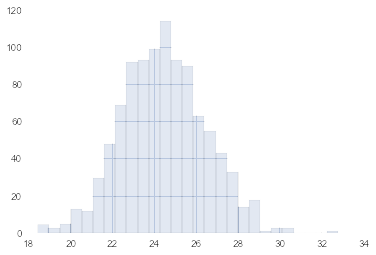

In [14]:
sns.distplot(samples, kde=False)

We see that the mean of this sampling distribution is right around the sample mean and the width of typical sample means is plus or minus 5 from our observed sample mean. We just estimated the sampling distribution by making nearly no assumptions about the data.

**Just To Prove It Works **

To prove to ourselves that this magic isn't nonsense, let's tackle a problem where we can readily verify the "right" answers. We're going to stick to a problem that's well within the bounds of classical statistics and Normal theory.

Let's say we go out in the world and measure the heights of 30 people. 

In [29]:
from numpy.random import normal

We imagine that the distributions of people's heights is a Gaussian distribution centered at 68 inches with a standard deviation of 10 inches. 

In [30]:
heightsData = normal(loc=68,scale=10,size=30)
heightsData

array([ 58.46054979,  72.27520668,  71.35447432,  75.95879597,
        72.08180987,  81.94011641,  65.06445374,  73.68254537,
        83.28552046,  63.39901491,  52.63954947,  86.44457094,
        53.3873169 ,  65.34473822,  69.25693681,  80.32810168,
        56.82133487,  64.89769766,  59.06782017,  64.14314371,
        70.34042848,  67.46133478,  72.06558143,  65.84445146,
        74.34769315,  80.58772931,  51.78859019,  54.35986427,
        64.71788467,  63.4633367 ])

This sample has a particular mean.

In [20]:
mean(heightsData)

66.542504305860049

But how can get a handle on the sampling distribution of that mean? That is, we only measured 30 people which is a quite small sample. So how different might this have turned out if we measured 30 other people? To get a quantification of the sampling distribution of the mean, we have two potential approaches. One is that we can turn to Monte Carlo methods and resimulate the data generating process. Another is that we can rely on classical statistical theory. Let's try both.

In [35]:
# monte carlo approach
mcSampleMeans=[]
for i in range(1000):
    mcHeightsData = normal(loc=68,scale=10,size=30)
    mcSampleMeans.append(mean(mcHeightsData))

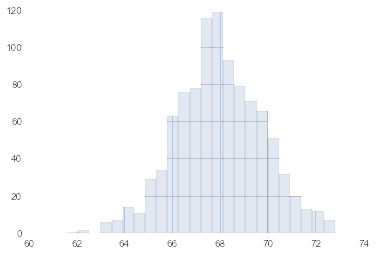

In [36]:
# hows it look
sns.distplot(mcSampleMeans, kde=False)

From Normal theory, the sampling distribution should be a Gaussian distribution centered at the sample mean. And the width of this Gaussian distribution is given by, 

$
\sigma_M^2 = \frac{\sigma^2}{N}
$

That is, it's the standard deviation of the true population ($\sigma^2$), divided by the sample size. In our case,

In [34]:
(10**2)/30

3

So Normal theory says the sampling distribution of our mean should look like this.

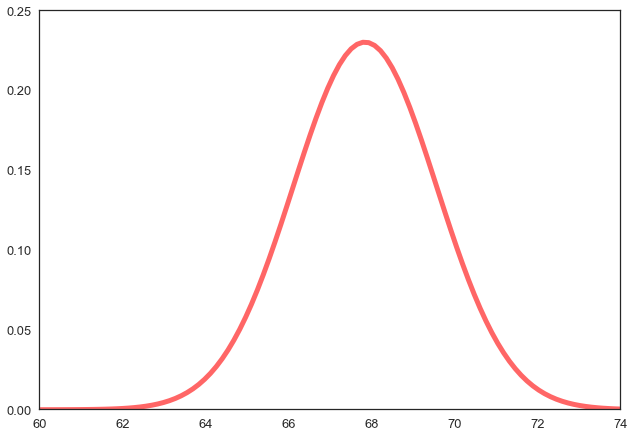

In [68]:
from scipy.stats import norm
x = np.linspace(60, 74, 100)
plt.plot(x, norm.pdf(x,loc=mean(heightsData),scale=np.sqrt(3)),'r-', lw=5, alpha=0.6)

Finally, let's try bootstrapping on this problem and see how the results compare.

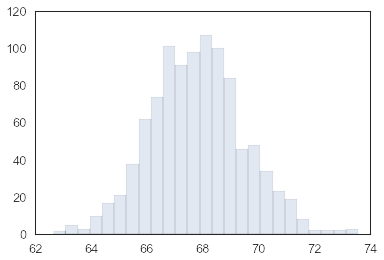

In [49]:
bootSampleMeans = bootstrap(heightsData, 1000, mean)
sns.distplot(bootSampleMeans,kde=False)

Let's view all of those together.

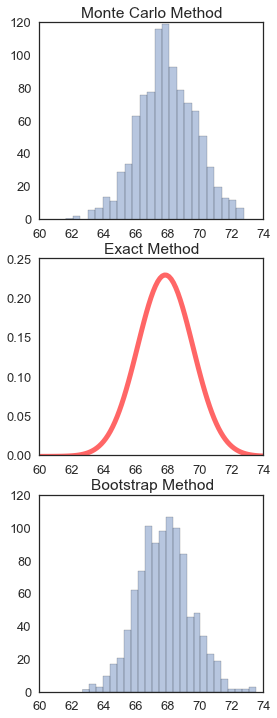

In [69]:
plt.rcParams['figure.figsize'] = (4, 12)
fig = plt.figure()
plt.subplot(311)
sns.distplot(mcSampleMeans, kde=False)
plt.xlim(60,74)
plt.title("Monte Carlo Method")
plt.subplot(312)
plt.plot(x, norm.pdf(x,loc=mean(heightsData),scale=np.sqrt(3)),'r-', lw=5, alpha=0.6)
plt.xlim(60,74)
plt.title("Exact Method")
plt.subplot(313)
sns.distplot(bootSampleMeans,kde=False)
plt.xlim(60,74)
plt.title("Bootstrap Method")

We see that the sampling distribution of the mean is really similar in each case. In the first case, we used Monte Carlo to repeatedly simulate the data generating process, and compute the sample mean at each step. In the second case, we relied on Normal theory (which was certainly valid in this case) to find an exact expression of what that sampling distribution of the mean is - a Gaussian distribution centered at the sample mean and with a variance that is calculated from the sample. And finally, we used bootstrapping to approximate the sampling distriubtion. In the last case, we assumed nothing about the data and used the simple idea of sample-with-replacement to generate synthetic datasets. Yet even in the assumption-free setting, we were able to easily come up with a great approximation to the true sampling distribution.

**Regression**

Let's continue these ideas with a slightly more complex example. For this example, let's read in some baseball statistics data.

In [106]:
plt.rcParams['figure.figsize'] = (8, 4)
import pandas as pd
baseball = pd.read_csv("./data/baseball.csv",na_values="NA",index_col="ID")

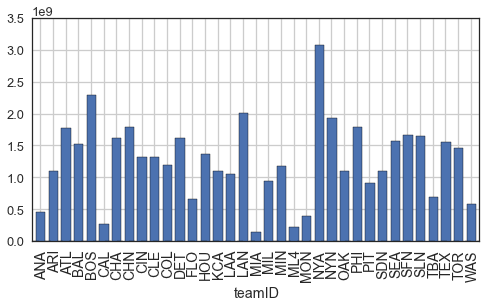

In [107]:
baseball.groupby(['teamID']).salary.sum().plot(kind='bar')

There's a lot of variability in the total salary spend of the various baseball teams, let's take a close look at how increases in salaray spending correlate with offense measures, such as number of team Batting Average.

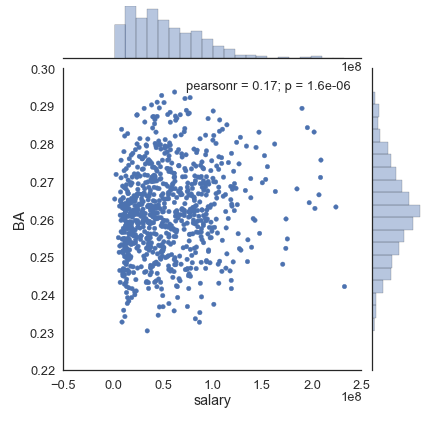

In [123]:
sns.jointplot(x='salary',y='BA',data=baseball)

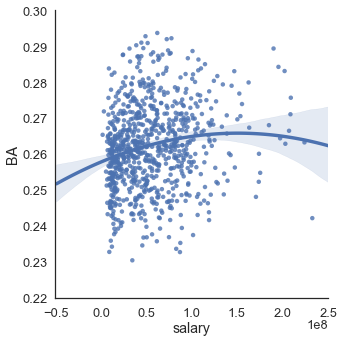

In [121]:
sns.lmplot(x='salary',y='BA',data=baseball,order=2)

In [147]:
baseball['salary_sq'] = baseball.salary ** .5

In [148]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(baseball[['salary_sq']], baseball.BA)


LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [149]:
linreg.coef_

array([  8.38046045e-07])

In [167]:
def sample_with_replacement_DF(someDF):
    df = pd.DataFrame(columns = someDF.columns)
    for i in range(someDF.shape[0]):
        df.loc[i]= someDF.loc[choice(range(someDF.shape[0]))]
    
    return df

def bootstrap4df(data,iterations,f):
    sampling_distribution = []
    for i in range(iterations):
        sampling_distribution.append(f(sample_with_replacement_DF(data)))
    return sampling_distribution


In [169]:
def fn(dataset):
    #linreg = LinearRegression()
    #linreg.fit(dataset[['salary_sq']], dataset.BA)
    #linreg.coef_
    dataset.shape[0]


samples = bootstrap4df(baseball,10,fn)

In [170]:
samples

[None, None, None, None, None, None, None, None, None, None]